In [1]:
#https://towardsdatascience.com/binary-classifier-evaluation-made-easy-with-handyspark-3b1e69c12b4f
#referencia https://medium.com/towards-artificial-intelligence/multi-class-text-classification-using-pyspark-mllib-doc2vec-dbfcee5b39f2
#https://swan-gallery.web.cern.ch/notebooks/apache_spark1/ML_Spark_MLlib.html
import findspark
findspark.init() 
from pyspark.sql import SparkSession
import os


MAX_MEMORY = "8g"
spark = SparkSession.builder \
                    .master("local") \
                    .appName('multi_class_text_classifiter')\
                    .config("spark.executor.memory", MAX_MEMORY) \
                    .config("spark.driver.memory", MAX_MEMORY) \
                    .config("spark.jars", "D:\\ML_text\\Servicios_web\\driverdb\\postgresql-42.2.5.jre6.jar") \
                    .getOrCreate()


#https://docs.anaconda.com/anaconda-scale/howto/spark-basic/

In [2]:
df_spark  = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5433/bd_biblioteca") \
    .option("dbtable", "documentos_estructurados") \
    .option("user", "postgres") \
    .option("password", "postgres1") \
    .option("driver", "org.postgresql.Driver") \
    .load()

df_spark.printSchema()

root
 |-- id_documento: long (nullable = true)
 |-- v0: double (nullable = true)
 |-- v1: double (nullable = true)
 |-- v2: double (nullable = true)
 |-- v3: double (nullable = true)
 |-- v4: double (nullable = true)
 |-- v5: double (nullable = true)
 |-- v6: double (nullable = true)
 |-- v7: double (nullable = true)
 |-- v8: double (nullable = true)
 |-- v9: double (nullable = true)
 |-- v10: double (nullable = true)
 |-- v11: double (nullable = true)
 |-- v12: double (nullable = true)
 |-- v13: double (nullable = true)
 |-- v14: double (nullable = true)
 |-- v15: double (nullable = true)
 |-- v16: double (nullable = true)
 |-- v17: double (nullable = true)
 |-- v18: double (nullable = true)
 |-- v19: double (nullable = true)
 |-- grupo: integer (nullable = true)



In [3]:
df_spark.count()

8076

In [4]:
df_spark=df_spark.drop('id_documento')
df_spark.printSchema()

root
 |-- v0: double (nullable = true)
 |-- v1: double (nullable = true)
 |-- v2: double (nullable = true)
 |-- v3: double (nullable = true)
 |-- v4: double (nullable = true)
 |-- v5: double (nullable = true)
 |-- v6: double (nullable = true)
 |-- v7: double (nullable = true)
 |-- v8: double (nullable = true)
 |-- v9: double (nullable = true)
 |-- v10: double (nullable = true)
 |-- v11: double (nullable = true)
 |-- v12: double (nullable = true)
 |-- v13: double (nullable = true)
 |-- v14: double (nullable = true)
 |-- v15: double (nullable = true)
 |-- v16: double (nullable = true)
 |-- v17: double (nullable = true)
 |-- v18: double (nullable = true)
 |-- v19: double (nullable = true)
 |-- grupo: integer (nullable = true)



In [5]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
transformed = transData(df_spark)
transformed.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.114150494,-0....|   14|
|[-1.4007652,-0.75...|   11|
|[-1.5759983,-1.75...|    0|
|[-0.63943255,-0.9...|   12|
|[0.32119328,0.208...|   27|
+--------------------+-----+
only showing top 5 rows



In [1]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)

# Identifique automáticamente características categóricas e indexelas.
# Establezca maxCategories para que las entidades con> 4 valores distintos se traten como continuas.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)


(trainingData, testData) = transformed.randomSplit([0.7, 0.3])
trainingData.show(5)

NameError: name 'StringIndexer' is not defined

<b>Arbol</b>

In [7]:
from pyspark.ml.classification import DecisionTreeClassifier

# Entrenar un modelo DecisionTree
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures',maxDepth = 20,minInstancesPerNode
                              =5,impurity='entropy')
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Canalizar el modelo mediante la tubería
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree,labelConverter])

# Train model.  This also runs the indexers.
arbol = pipeline.fit(trainingData)


<b>RandomForest</b>

In [8]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=500,maxDepth = 10,
                       minInstancesPerNode=5,impurity='gini'  )
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

# Train model.  This also runs the indexers.
randomforest = pipeline.fit(trainingData)




<b>Naive Bayes</b>

In [9]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(featuresCol='indexedFeatures', labelCol='indexedLabel')

labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, nb,labelConverter])

# Train model.  This also runs the indexers.
#naivebayes = pipeline.fit(trainingData)


<b>LogisticRegression</b>

In [12]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel',regParam=0.001)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

logregre = pipeline.fit(trainingData)

<b>Train neural network</b>

In [16]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
# specify layers for the neural network:
# input layer of size 11 (features), two intermediate of size 5 and 4
# and output of size 7 (classes)
layers = [20, 10 , 32]

# create the trainer and set its parameters
FNN = MultilayerPerceptronClassifier(labelCol="indexedLabel", \
                                     featuresCol="indexedFeatures",\
                                     maxIter=3000, layers=layers, \
                                     blockSize=128, seed=1234)
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Chain indexers and forest in a Pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, FNN, labelConverter])
# train the model
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [3]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

def eval_model(testData,trainingData,model,metric):
    predictions_test = model.transform(testData)
    predictions_train = model.transform(trainingData)
    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName=metric)
    accuracy_test = evaluator.evaluate(predictions_test)
    accuracy_train = evaluator.evaluate(predictions_train)
    print(metric+"test = %g" % (accuracy_test))
    print(metric+"train = %g" % (accuracy_train))

    rfModel = model.stages[-2]
    print(rfModel)  # summary only

metricas=["weightedPrecision","accuracy","f1","weightedRecall"] 
eval_model(testData,trainingData,arbol,metricas[2])   
eval_model(testData,trainingData,randomforest,metricas[2])  
eval_model(testData,trainingData,logregre,metricas[2]) 
eval_model(testData,trainingData,model,metricas[2])   

NameError: name 'testData' is not defined

<b>Tunear Parámatros LogisticRegression</b>

In [50]:
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

paramGrid = (ParamGridBuilder()
             .addGrid(logr.regParam, [0.001, 0.01, 0.1, 0.5, 1.0, 2.0])
             #  .addGrid(lr.regParam, [0.01, 0.1, 0.5])
             .addGrid(logr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             #  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(logr.maxIter, [1, 5, 10, 20, 50])
             #  .addGrid(lr.maxIter, [1, 5, 10])
             .build())

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName=metricas[1]),
                          numFolds=3)  # use 3+ folds in practice

cvModel = crossval.fit(trainingData)

In [99]:
# Get Model Summary Statistics
metricas=["weightedPrecision","accuracy","f1","weightedRecall"]
lrcvSummary = cvModel.bestModel
eval_model(testData,trainingData,lrcvSummary,metricas[1])  
import numpy as np
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]
lrcvSummary.stages[2].getRegParam()


accuracytest = 0.9046
accuracytrain = 0.929644
LogisticRegressionModel: uid=LogisticRegression_9c49e39e8de6, numClasses=32, numFeatures=20


0.001

<b>Tunear Red neuronal</b>

In [78]:
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

paramGrid = (ParamGridBuilder()
             .addGrid(FNN.layers,[[20, 1 , 32],[20, 5 , 32]])
             .build())

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName=metricas[1]),
                          numFolds=3)  # use 3+ folds in practice

cvModel = crossval.fit(trainingData)

In [82]:
# Get Model Summary Statistics
metricas=["weightedPrecision","accuracy","f1","weightedRecall"]
lrcvSummary = cvModel.bestModel
eval_model(testData,trainingData,lrcvSummary,metricas[1])  
import numpy as np
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]
lrcvSummary.stages[2].getLayers()

accuracytest = 0.749484
accuracytrain = 0.76455
MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_7d851b4c2730, numLayers=3, numClasses=32, numFeatures=20


[20, 5, 32]

<b>Tunear arbol</b>

In [113]:
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

paramGrid = (ParamGridBuilder()
             .addGrid(dTree.maxDepth,[5,10,20])
             .addGrid(dTree.minInstancesPerNode,[5,10,20])
             .addGrid(dTree.impurity,['entropy','gini'])
             .build())

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName=metricas[1]),
                          numFolds=3)  # use 3+ folds in practice

cvModel = crossval.fit(trainingData)

In [114]:
# Get Model Summary Statistics
metricas=["weightedPrecision","accuracy","f1","weightedRecall"]
lrcvSummary = cvModel.bestModel
eval_model(testData,trainingData,lrcvSummary,metricas[1])  
import numpy as np
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]
print(lrcvSummary.stages[2].getMaxDepth())
print(lrcvSummary.stages[2].getMinInstancesPerNode())
print(lrcvSummary.stages[2].getImpurity())

accuracytest = 0.666525
accuracytrain = 0.857716
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_53930b5dd60b, depth=17, numNodes=785, numClasses=32, numFeatures=20
20
5
entropy


<b>Tunear RandomForest</b>

In [14]:
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
metricas=["weightedPrecision","accuracy","f1","weightedRecall"]
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth,[10])
             .addGrid(rf.minInstancesPerNode,[5])
             .addGrid(rf.impurity,['gini'])
             .addGrid(rf.numTrees,[100])
             .addGrid(rf.minWeightFractionPerNode,[0.0,0.05])    
             .addGrid(rf.minInfoGain,[0.0,0.025])    
             .build())

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName=metricas[1]),
                          numFolds=3)  # use 3+ folds in practice

cvModel = crossval.fit(trainingData)

In [1]:
# Get Model Summary Statistics
metricas=["weightedPrecision","accuracy","f1","weightedRecall"]
lrcvSummary = cvModel.bestModel
eval_model(testData,trainingData,lrcvSummary,metricas[1])  
import numpy as np
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]
print(lrcvSummary.stages[2].getMaxDepth())
print(lrcvSummary.stages[2].getMinInstancesPerNode())
print(lrcvSummary.stages[2].getImpurity())
#print(lrcvSummary.stages[2].getNumTrees())
print(lrcvSummary.stages[2].getMinWeightFractionPerNode())
print(lrcvSummary.stages[2].getMinInfoGain())

NameError: name 'cvModel' is not defined

<b>XGBOOST</b>

In [5]:
result_pdf = df_spark.select("*").toPandas()
result_pdf.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v11,v12,v13,v14,v15,v16,v17,v18,v19,grupo
0,-0.114150,-0.470316,0.066456,0.396812,0.309713,0.309934,0.158930,-0.143244,-0.608666,-0.551357,...,0.613506,-0.290649,1.717429,-0.235506,1.411399,0.050213,-0.414502,0.319806,0.124243,14
1,-1.400765,-0.759957,0.303883,-0.182143,-0.920323,-2.764483,-0.903704,-0.725012,0.514106,-0.454643,...,1.069958,0.102657,-0.283214,-0.802116,0.984764,-1.758157,0.147815,-0.438175,0.536742,11
2,-1.575998,-1.754042,0.436943,1.178827,0.035127,0.257678,-0.347408,0.094753,-0.804367,-0.363128,...,1.356802,0.374073,0.879407,-0.144139,0.448543,-0.533359,-1.299521,0.691233,-1.100710,0
3,-0.639433,-0.981315,0.114390,0.046880,-1.094180,-0.790529,-1.639304,-0.020987,-0.812094,0.240467,...,-0.667463,-0.049547,0.676034,0.229995,-0.032693,0.461650,-0.994536,1.019752,-0.421853,12
4,0.321193,0.208476,0.438890,0.166335,0.298484,0.167771,-0.281270,-0.841791,0.431160,-0.698627,...,-0.382391,0.452839,1.686943,-0.072980,1.211647,-0.088271,0.297298,0.665430,-0.706013,27


In [7]:
from sklearn.model_selection import train_test_split

Y=result_pdf['grupo']
X=result_pdf.drop(labels=['grupo'],axis=1)

X_train,X_test,y_train,y_test=train_test_split(X,Y,
                                               test_size=0.3,
                                               random_state=5)

In [31]:
from xgboost import XGBClassifier

params = {'objective':'multisoft:prob',
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 3, 'alpha': 0,
          'n_estimators':1000}

params={
 'objective':'multisoft:prob',
 'alpha': 0,
 'booster': 'gblinear',
 'eta': 0.3,
 'gamma': 0,
 'lambda': 0,
 #'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 1000,
 'n_job': -1}

modelo = XGBClassifier(**params)
modelo.fit(X_train, y_train)

XGBClassifier(alpha=0, base_score=0.5, booster='gblinear',
       colsample_bylevel=None, colsample_bynode=None,
       colsample_bytree=None, eta=0.3, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None, lambda=0,
       learning_rate=0.300000012, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=1000, n_job=-1, n_jobs=0, num_parallel_tree=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=None)

In [32]:
from joblib import dump, load # Guardar/Cargar modelos
dump(modelo,"./Modelos/XGBOOST.DAT")

['./Modelos/XGBOOST.DAT']

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score,precision_score,classification_report,balanced_accuracy_score,f1_score




def eval_model(testData,trainingData,y_test,y_train,model):
    predictions_test = model.predict(testData)
    predictions_train = model.predict(trainingData)
    # Select (prediction, true label) and compute test error
    print("accuracy test:",accuracy_score(y_test, predictions_test))
    print("accuracy train:",accuracy_score(y_train, predictions_train))
    
    print("Balanced_accuracy test:",balanced_accuracy_score(y_test, predictions_test))
    print("Balanced_accuracy train:",balanced_accuracy_score(y_train, predictions_train))
    
    print("F1 test:",f1_score(y_test, predictions_test,average='macro'))
    print("F1 train:",f1_score(y_train, predictions_train,average='macro'))
    
    return (balanced_accuracy_score(y_test, predictions_test))
    #return (f1_score(y_test, predictions_test,average='macro'))
    
eval_model(X_test,X_train,y_test,y_train,modelo)

accuracy test: 0.9063144861741642
accuracy train: 0.9566601804351672
Balanced_accuracy test: 0.9110869779951697
Balanced_accuracy train: 0.9687907278828277
F1 test: 0.9111531143153737
F1 train: 0.9682926609984461


0.9110869779951697

In [18]:
import matplotlib.pyplot as plt
import itertools
# Función para plot de la matriz de confusión
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


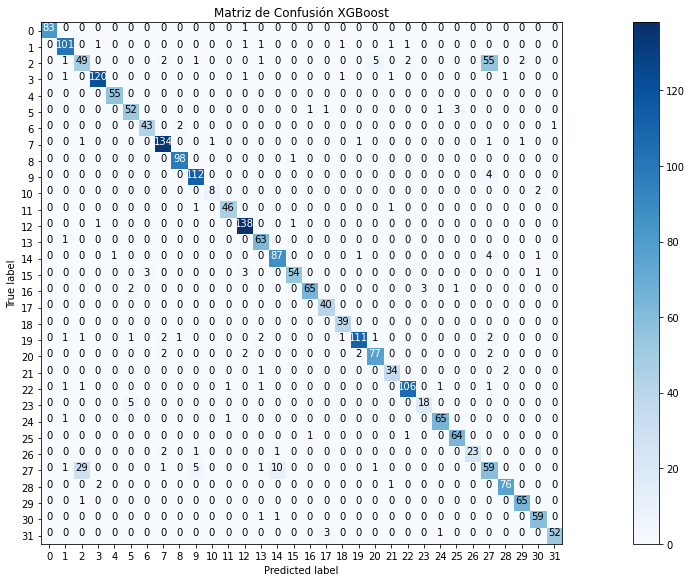

In [30]:
import numpy as np
class_names = [i for i in range(32)]

cnf_matrix = confusion_matrix(y_test, modelo.predict(X_test)) 
np.set_printoptions(precision=2)
plt.figure(figsize = (20,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Matriz de Confusión XGBoost')
plt.savefig('./Imagenes/mconf.png')

<b>Tunear XGBOOST</b>

In [100]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.balanced_accuracy_score(Y, self.predictions)))



# Este proceso tarda mucho, fue necesario hacerlo en una maquina propia
from sklearn.model_selection import GridSearchCV
# Se utiliza gridsearch como modelo de selección para determinar los mejores parametros en XGBoost
gb = Class_Fit(clf = XGBClassifier)
param_grid = {'n_estimators' : [500],'learning_rate':[0.1],'max_depth':[3],'n_job':[-1],'alpha':[0],
             'booster':['gblinear','gbtree'],
              'eta':[0.3,0.01],'min_child_weight':[1,5],
              'gamma':[0,1],'max_delta_step':[0,1],
              'lambda':[0,1]
             }
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = y_train)

In [101]:
# Muestra los mejores parámetros para el modelo evaluado
gb.grid_predict(X_test, y_test)
gb.grid.best_params_

Precision: 90.62 % 


{'alpha': 0,
 'booster': 'gblinear',
 'eta': 0.3,
 'gamma': 0,
 'lambda': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 500,
 'n_job': -1}

In [33]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score,precision_score, balanced_accuracy_score, recall_score


from sklearn.model_selection import StratifiedKFold

def validacion_cruzada(x_train,y_train,kfolds,model):
    cv = StratifiedKFold(n_splits=kfolds,shuffle=False)
    prom=[]
    for train,test in cv.split(x_train,y_train):
    
        modelo=model.fit(x_train.iloc[train],y_train.iloc[train])
        prom.append(eval_model(x_train.iloc[test],x_train.iloc[train],y_train.iloc[test],y_train.iloc[train],modelo))

    return(prom) 

In [35]:
# Se realiza validación cruzada pasando cuantas particiones del conjuto de datos quiere entrenar
kflods = 4
auc_vec=validacion_cruzada(X_train,y_train, kflods, modelo)

print('-------------------------')
display(auc_vec)
print('-------------------------')
print('Promedio', sum(auc_vec)/len(auc_vec)) 

accuracy test: 0.896358543417367
accuracy train: 0.9583431952662722
Balanced_accuracy test: 0.8868007528949042
Balanced_accuracy train: 0.9701652628622048
F1 test: 0.8895836878870262
F1 train: 0.9698768552582824
accuracy test: 0.8990112994350282
accuracy train: 0.9596412556053812
Balanced_accuracy test: 0.9051172866024126
Balanced_accuracy train: 0.9710505635543492
F1 test: 0.8987062262381308
F1 train: 0.9708028364593208
accuracy test: 0.9055397727272727
accuracy train: 0.9564193168433451
Balanced_accuracy test: 0.9137427172565595
Balanced_accuracy train: 0.9685814099174102
F1 test: 0.9131804516046287
F1 train: 0.9680852966619162
accuracy test: 0.892933618843683
accuracy train: 0.9651928504233303
Balanced_accuracy test: 0.8937095948100064
Balanced_accuracy train: 0.9750649895432982
F1 test: 0.8937818095711116
F1 train: 0.9746674324130924
-------------------------


[0.8895836878870262,
 0.8987062262381308,
 0.9131804516046287,
 0.8937818095711116]

-------------------------
Promedio 0.8988130438252243


<b>Regresión Logística</b>

In [64]:
from sklearn import linear_model # Regresión logistica
# Este proceso tarda mucho, fue necesario hacerlo en una maquina propia
from sklearn.model_selection import GridSearchCV
# Se utiliza gridsearch como modelo de selección para determinar los mejores parametros en XGBoost
gb = Class_Fit(clf = linear_model.LogisticRegression)
param_grid = {'max_iter' : [10000],'penalty':['l1', 'l2'],
              'class_weight':[None,'balanced'],'solver':['liblinear'],
              'n_jobs':[-1],'multi_class':['auto', 'ovr']
             ,}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = y_train)

C:\Users\JBARCO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\JBARCO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\JBARCO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\JBARCO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\JBARCO\Anaconda3\lib\site-packages\

C:\Users\JBARCO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\JBARCO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\JBARCO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\JBARCO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\JBARCO\Anaconda3\lib\site-packages\

In [65]:
# Muestra los mejores parámetros para el modelo evaluado
gb.grid_predict(X_test, y_test)
gb.grid.best_params_

Precision: 90.51 % 


{'class_weight': 'balanced',
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [68]:
params={'class_weight': 'balanced',
 'max_iter': 100000,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l1',
 'solver': 'liblinear'}

model_rlog_balanced = linear_model.LogisticRegression(**params)

In [69]:
# Se realiza validación cruzada pasando cuantas particiones del conjuto de datos quiere entrenar
kflods = 4
auc_vec=validacion_cruzada(X_train,y_train, kflods, model_rlog_balanced)

print('-------------------------')
display(auc_vec)
print('-------------------------')
print('Promedio', sum(auc_vec)/len(auc_vec)) 

C:\Users\JBARCO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


accuracy test: 0.8823529411764706
accuracy train: 0.9105325443786982
Balanced_accuracy test: 0.8958020428876097
Balanced_accuracy train: 0.9277062282323347


C:\Users\JBARCO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


accuracy test: 0.8862994350282486
accuracy train: 0.9096058531980175
Balanced_accuracy test: 0.9011986435789235
Balanced_accuracy train: 0.9253639896791357


C:\Users\JBARCO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


accuracy test: 0.8828125
accuracy train: 0.9076560659599529
Balanced_accuracy test: 0.8960375229833814
Balanced_accuracy train: 0.9237636359497942


C:\Users\JBARCO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


accuracy test: 0.8793718772305497
accuracy train: 0.9118062088428974
Balanced_accuracy test: 0.8958320229486594
Balanced_accuracy train: 0.9253162816555051
-------------------------


[0.8958020428876097,
 0.9011986435789235,
 0.8960375229833814,
 0.8958320229486594]

-------------------------
Promedio 0.8972175580996434


<b>Graficar Resultados</b>

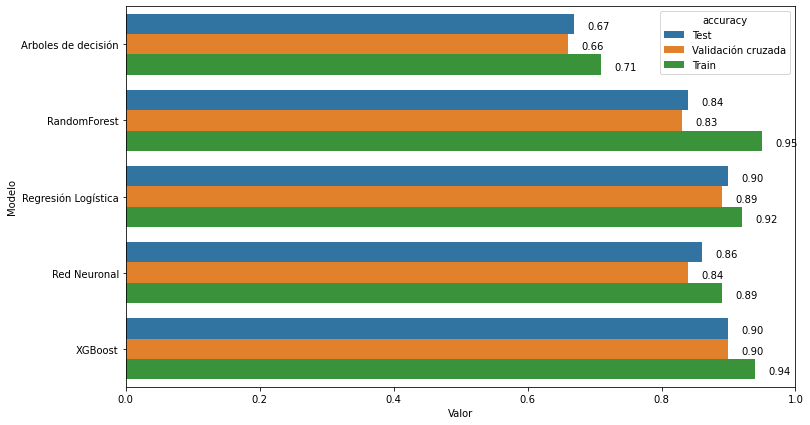

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = []
data.append(['Arboles de decisión','Test',0.67])
data.append(['Arboles de decisión','Validación cruzada',0.66])
data.append(['Arboles de decisión','Train',0.71])


data.append(['RandomForest', 'Test',0.84])
data.append(['RandomForest','Validación cruzada',0.83])
data.append(['RandomForest','Train',0.95])


data.append(['Regresión Logística','Test',0.9])
data.append(['Regresión Logística','Validación cruzada',0.89])
data.append(['Regresión Logística','Train',0.92])


data.append(['Red Neuronal', 'Test',0.86])
data.append(['Red Neuronal','Validación cruzada',0.84])
data.append(['Red Neuronal','Train',0.89])


data.append(['XGBoost','Test',0.90])
data.append(['XGBoost','Validación cruzada',0.90])
data.append(['XGBoost','Train',0.94])




# crear DF
df_results = pd.DataFrame(data, columns = ['Modelo', 'accuracy', 'Valor'])
# Config de plot
plt.figure(figsize=(12,7))
plt.xlim(0,1)
# Plot 
ax = sns.barplot(x="Valor", y="Modelo", hue="accuracy", data=df_results)
labels = ax.get_xticklabels()
# labels in bars
for p in ax.patches:  
      ax.annotate('{:.2f}'.format(p.get_width()), #{:.2f}
              (p.get_x() + p.get_width() + 0.02, p.get_y()+0.2))  
plt.savefig('./Imagenes/clasificadoresA.png')

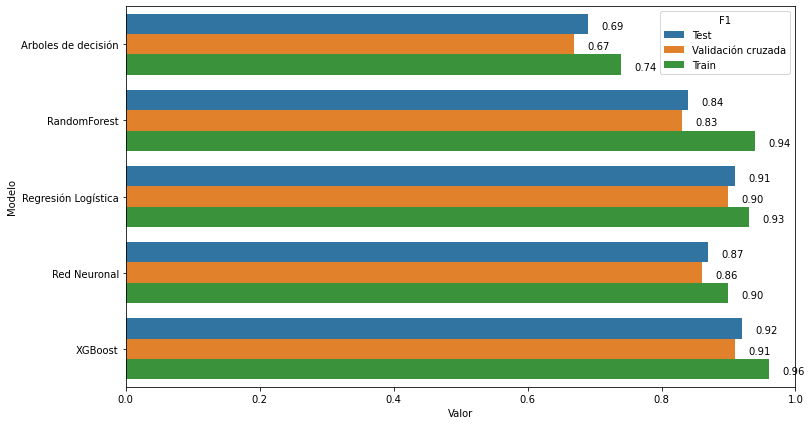

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = []
data.append(['Arboles de decisión','Test',0.69])
data.append(['Arboles de decisión','Validación cruzada',0.67])
data.append(['Arboles de decisión','Train',0.74])

data.append(['RandomForest', 'Test',0.84])
data.append(['RandomForest','Validación cruzada',0.83])
data.append(['RandomForest','Train',0.94])

data.append(['Regresión Logística','Test',0.91])
data.append(['Regresión Logística','Validación cruzada',0.9])
data.append(['Regresión Logística','Train',0.93])

data.append(['Red Neuronal', 'Test',0.87])
data.append(['Red Neuronal','Validación cruzada',0.86])
data.append(['Red Neuronal','Train',0.90])

data.append(['XGBoost','Test',0.92])
data.append(['XGBoost','Validación cruzada',0.91])
data.append(['XGBoost','Train',0.96])



# crear DF
df_results = pd.DataFrame(data, columns = ['Modelo', 'F1', 'Valor'])
# Config de plot
plt.figure(figsize=(12,7))
plt.xlim(0,1)
# Plot 
ax = sns.barplot(x="Valor", y="Modelo", hue="F1", data=df_results)
labels = ax.get_xticklabels('{:20f}')
# labels in bars
for p in ax.patches:  
      ax.annotate('{:.2f}'.format(p.get_width()), #{:.2f}
              (p.get_x() + p.get_width() + 0.02, p.get_y()+0.2))  
plt.savefig('./Imagenes/clasificadoresF1.png')